### Explorando o Dataset

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# Carregar dataset
raw_dataset = pd.read_csv('data/output.csv')
raw_dataset.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Activity,Stage
0,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,15/07/2019 01:55:21 PM,119998944,242,1,...,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,Normal,Benign
1,192.168.3.10-239.2.11.71-53569-8662-17,192.168.3.10,53569,239.2.11.71,8662,17,15/07/2019 01:55:22 PM,109235816,21,1,...,819535.500000,78517.844090,875056.0,764015.0,1.517532e+07,6.349189e+06,20019201.0,5202524.0,Normal,Benign
2,255.255.255.255-0.0.0.0-67-68-17,0.0.0.0,68,255.255.255.255,67,17,15/07/2019 01:55:22 PM,119764062,88,1,...,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,Normal,Benign
3,192.168.3.30-192.168.3.31-40504-9200-6,192.168.3.30,40504,192.168.3.31,9200,6,15/07/2019 01:55:23 PM,117030424,18,17,...,192329.333333,436593.123269,1083374.0,7236.0,1.931131e+07,1.177830e+07,34978598.0,5147962.0,Normal,Benign
4,0.87.248.248-3.0.0.0-0-0-0,0.87.248.248,0,3.0.0.0,0,0,15/07/2019 01:55:58 PM,119999703,2,1,...,0.000000,0.000000,0.0,0.0,5.999985e+07,8.478210e+02,60000451.0,59999252.0,Normal,Benign


c:\Users\Alfredo\source\repos\cyberdata-improvement-tts-cgan\data\DataLoader.py:55: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_train['Timestamp'] = pd.to_datetime(data_train['Timestamp'], errors='coerce')


Foram removidos 5382 outliers


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


X train shape is (1897, 30, 6)
Y train shape is (1897,)
Quantidade de amostras da classe benign: 1657
Quantidade de amostras da classe reconnaissance: 505
Quantidade de amostras da classe establish foothold: 365
Quantidade de amostras da classe lateral movement: 174
Quantidade de amostras da classe data exfiltration: 10


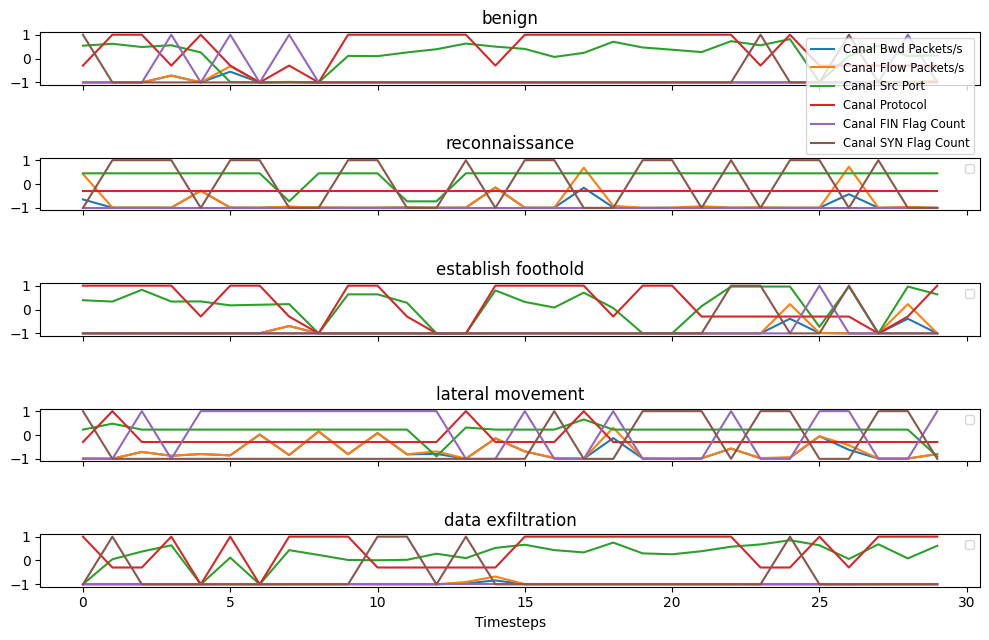

In [35]:
from data.DataLoader import load_and_preprocess_data
import numpy as np
# Carregar e pré-processar os dados
features_to_train = ['Bwd Packets/s', 'Flow Packets/s', 'Src Port', 'Protocol', 'FIN Flag Count', 'SYN Flag Count', 'Timestamp']
label_column = 'Stage'
seq_len = 30
filename = "data/output.csv"

#ja embaralhado por padrao
data_set = load_and_preprocess_data(filename, features_to_train, label_column, seq_len, expand=False)
X_train = data_set.X_set
Y_train = data_set.Y_set #labels
class_names = data_set.classes
# cada sequencia possui 6 canais e 30 timesteps, plotar uma amostra de cada labels
# Obter rótulos únicos
labels = np.unique(Y_train)
# Índices do primeiro exemplo de cada label
examples_idx = [np.where(Y_train == label)[0][0] for label in labels]

# Parâmetros
_, T, C = X_train.shape
colors = plt.cm.tab10.colors  # até 10 cores distintas

# Criar subplots
fig, axs = plt.subplots(len(labels), 1, figsize=(10, 1.3*len(labels)), sharex=True)

for i, (label, idx) in enumerate(zip(labels, examples_idx)):
    axs[i].set_title(f"{class_names[label]}")
    for c in range(C):
        if label == 0:
            axs[i].plot(X_train[idx, :, c], label=f"Canal {features_to_train[c]}", color=colors[c % len(colors)])
        else:
            axs[i].plot(X_train[idx, :, c], color=colors[c % len(colors)])
    axs[i].legend(loc='upper right', fontsize='small')

plt.xlabel("Timesteps")
plt.tight_layout()
plt.show()


#### Features com maior correlação com o estágio do ataque

Dataset final: 86691 linhas, 79 colunas


C:\Users\Alfredo\AppData\Local\Temp\ipykernel_1644\2886308080.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation.values, y=correlation.index, palette="viridis")


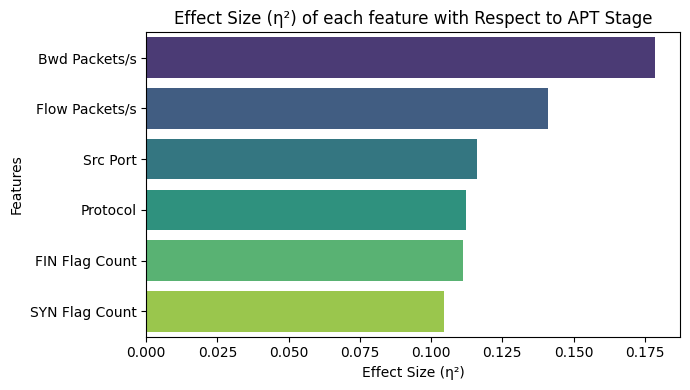

Attributos de maior correlação: ['Bwd Packets/s', 'Flow Packets/s', 'Src Port', 'Protocol', 'FIN Flag Count', 'SYN Flag Count']


In [11]:
import seaborn as sns
import pandas as pd
import numpy as np

# Converter a label para numérico (caso seja categórica)
label_name = 'Stage'

labels = raw_dataset[label_name]
raw_dataset = raw_dataset.drop(columns=[label_name])

# Converter colunas para numérico e diagnosticar
dataset = raw_dataset.apply(pd.to_numeric, errors='coerce')

# Se muitas colunas foram convertidas para NaN, tentar identificar o problema
if dataset.isna().sum().sum() > 0.9 * dataset.size:
    print("⚠️ Muitas colunas viraram NaN! Pode ser erro na conversão.")

# Remover colunas com 100% de NaNs
dataset = dataset.dropna(axis=1, how='all')

# Agora remover apenas linhas onde muitas colunas são NaN (evitar remover tudo)
dataset = dataset.dropna(thresh=int(0.5 * dataset.shape[1]))  # Mantém linhas com pelo menos 50% das colunas preenchidas

# to lower
if labels.dtype == object:
    labels = labels.str.lower()

#converte as labels para numérico da seguinte forma, benign = 0, reconnaissance = 1, establish foothold" = 2, lateral movement = 3, exfiltration = 
#labels = labels.map({
#    'benign': 0,
#    'reconnaissance': 1,
#    'establish foothold': 2,
#    'lateral movement': 3,
#    'exfiltration': 4
#})


# Verificar se ainda há dados
print(f"Dataset final: {dataset.shape[0]} linhas, {dataset.shape[1]} colunas")

# Calcular eta squared (η²) para cada atributo numérico em relação à label categórica
def eta_squared(X, y):
    """
    Calcula o eta squared (η²) entre cada coluna de X e a variável categórica y.
    """

    results = {}
    y = pd.Series(y)
    for col in X.columns:
        groups = []
        for level in y.unique():
            groups.append(X.loc[y == level, col].dropna())
        # Soma dos quadrados total
        all_values = pd.concat(groups)
        grand_mean = all_values.mean()
        ss_total = ((all_values - grand_mean) ** 2).sum()
        # Soma dos quadrados entre grupos
        ss_between = sum([len(g) * (g.mean() - grand_mean) ** 2 for g in groups])
        # Eta squared
        eta2 = ss_between / ss_total if ss_total > 0 else np.nan
        results[col] = eta2
    return pd.Series(results)

eta2 = eta_squared(dataset, labels)
eta2 = eta2[eta2.abs() > 0.1]  # Filtrar correlações maiores que 0.1
eta2 = eta2.abs().sort_values(ascending=False)
correlation = eta2  # para manter compatibilidade com o restante do código

plt.figure(figsize=(7, 4))
sns.barplot(x=correlation.values, y=correlation.index, palette="viridis")
plt.xlabel("Effect Size (η²)")
plt.ylabel("Features")
plt.title('Effect Size (η²) of each feature with Respect to APT Stage')
plt.tight_layout()
plt.savefig("images/effect_size.pdf")
plt.show()
print(f"Attributos de maior correlação: {list(correlation.index)}")

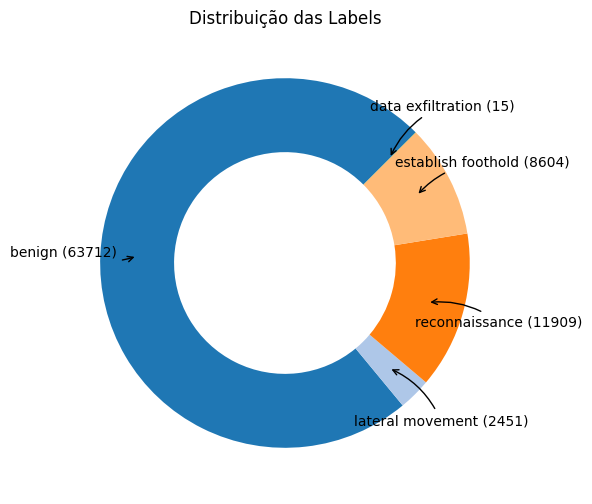

In [22]:
from collections import Counter

# Contar a ocorrência de cada label
label_counts = Counter(labels)
labels_key = list(label_counts.keys())
sizes = list(label_counts.values())

# Cores opcionais
colors = plt.cm.tab20.colors

# Criar gráfico do tipo "donut"
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts = ax.pie(
    sizes, labels=None, startangle=45, colors=colors, wedgeprops=dict(width=0.4)
)

# Adicionar setas com nomes e quantidades
for i, (wedge, label, count) in enumerate(zip(wedges, labels_key, sizes)):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.radians(angle))
    y = np.sin(np.radians(angle))

    ax.annotate(
        f'{label} ({count})',
        xy=(x * 0.8, y * 0.8),
        xytext=(x * 1.2, y * 1.2),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),
        ha='center',
        va='center'
    )

# Estilo de donut
ax.set(aspect="equal")
plt.title("Distribuição das Labels")

plt.savefig("images/labels_distribution.pdf")
plt.show()
#salvar grafico

#### Pré-Processamento

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from data.DataLoader import load_and_preprocess_data

seq_len = 30
features_to_train = ['SYN Flag Count', 'Src Port', 'Fwd Packets/s', 'Flow Packets/s', 'Bwd Packets/s', 'ACK Flag Count', 'FIN Flag Count', 'Flow Bytes/s', 'Timestamp']
train_set = load_and_preprocess_data("data/output.csv", features_to_train, "Stage", seq_len, is_train=True)

Foram removidos 4768 outliers
X shape is (1889, 8, 1, 30)
Y shape is (1889,)
Quantidade de amostras da classe benign: 1142
Quantidade de amostras da classe data exfiltration: 6
Quantidade de amostras da classe establish foothold: 260
Quantidade de amostras da classe lateral movement: 125
Quantidade de amostras da classe reconnaissance: 356


In [2]:
x_train = train_set.X_set
y_train = train_set.Y_set

In [3]:
def plot_samples(data, classnames, labels=None, offset=0):
    fig, axs = plt.subplots(2, 5, figsize=(20, 5))
    fig.suptitle('Network Traffic', fontsize=15)

    # Definição de cores
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    num_samples = data.shape[0]
    num_classes = len(classnames)

    for i in range(2):
        for j in range(5):
            sample_idx = i * 5 + j + offset
            if sample_idx >= num_samples:
                break  # Evita acessar índices fora do alcance de 'data'
            for k in range(1, num_classes):
                if k >= len(colors):
                    break  # Evita acessar índices fora do alcance de 'colors'
                axs[i, j].plot(data[sample_idx, k, 0, :], color=colors[k], label=classnames[k])

            # Alteração da cor de fundo com base no rótulo
            if labels is not None:
                if sample_idx < len(labels):
                    axs[i, j].set_facecolor('lightcoral' if labels[sample_idx] == 1 else 'lightblue')

    # Criação da legenda
    handles = [plt.Line2D([0], [0], color=colors[k], lw=2) for k in range(1, num_classes) if k < len(colors)]
    fig.legend(handles, classnames[1:num_classes], loc='upper right', fontsize=12)

    plt.show()


In [44]:
def plot_n_samples(data, classnames, num_samples, labels=None, offset = 0):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['b', 'r']  # Azul para a primeira variável, vermelho para a segunda
    count = 0

    for i in range(num_samples):
        seq_len = data.shape[-1]
        x = np.arange(seq_len) + count  # Ajusta a posição no eixo x para evitar sobreposição
        ax.plot(x, data[i + offset, 0, 0, :], color=colors[0], label=classnames[0] if i == 0 else "")
        ax.plot(x, data[i + offset, 1, 0, :], color=colors[1], label=classnames[1] if i == 0 else "")
        count += seq_len  # Move o próximo conjunto de dados para a direita

    if labels is not None:
        for i in range(num_samples):
            if labels[i + offset] == 0:
                ax.axvspan(i * seq_len, (i + 1) * seq_len, color='lightgreen', alpha=0.5)
            else:
                ax.axvspan(i * seq_len, (i + 1) * seq_len, color='lightcoral', alpha=0.5)

    plt.title("Trafego de rede")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.show()


## Gerando dados sintéticos

In [ ]:
import matplotlib.pyplot as plt
from TTSCGAN.generate_data import *

In [5]:
data_path = "data/output.csv"
CGAN_model_path = 'logs/TTS_APT_CGAN_2025_04_19_22_18_04/Model/checkpoint'
features = ['SYN Flag Count', 'Src Port', 'Fwd Packets/s', 'Flow Packets/s', 'Bwd Packets/s', 'ACK Flag Count', 'FIN Flag Count', 'Flow Bytes/s', 'Timestamp']
seq_len = 30

syntetic_set =  recreate_dataset(data_path, CGAN_model_path, features, seq_len)
x_synt = syntetic_set.X_set
y_synt = syntetic_set.Y_set

Foram removidos 4768 outliers
X shape is (1889, 8, 1, 30)
Y shape is (1889,)
Quantidade de amostras da classe benign: 1142
Quantidade de amostras da classe data exfiltration: 6
Quantidade de amostras da classe establish foothold: 260
Quantidade de amostras da classe lateral movement: 125
Quantidade de amostras da classe reconnaissance: 356


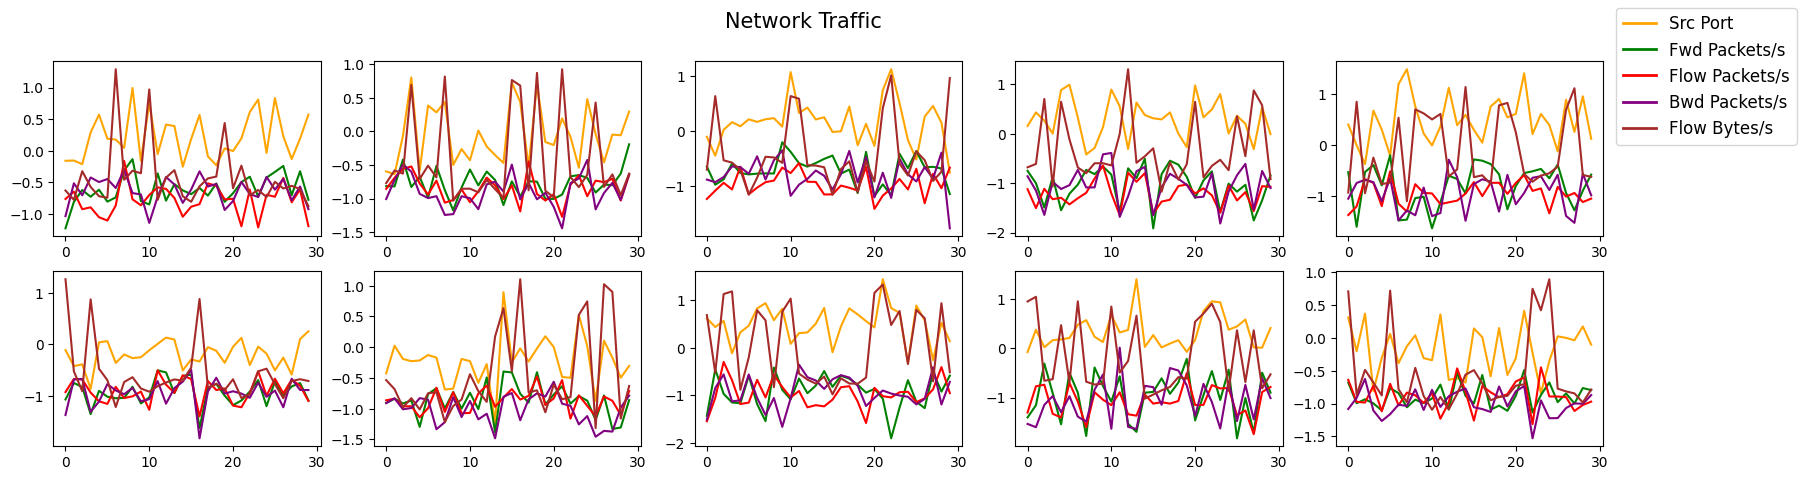

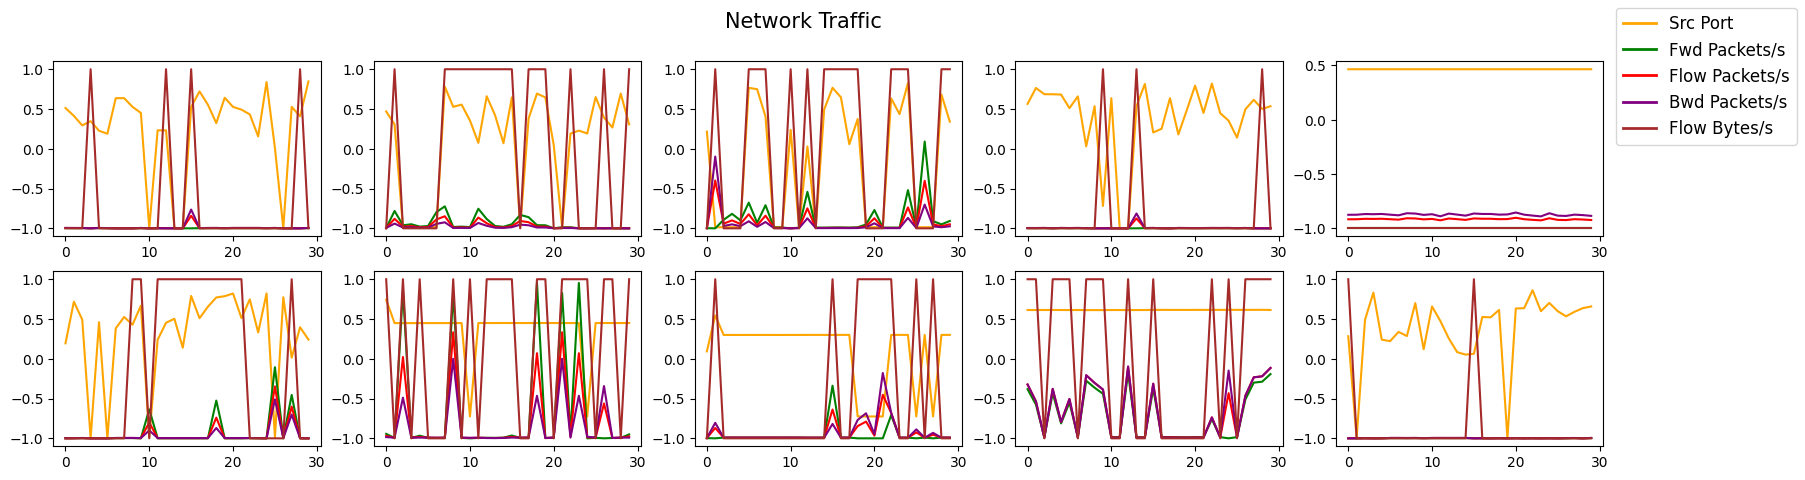

In [6]:
plot_samples(x_synt[180:300, :], ['SYN Flag Count', 'Src Port', 'Fwd Packets/s', 'Flow Packets/s', 'Bwd Packets/s', 'Flow Bytes/s'])
plot_samples(x_train, ['SYN Flag Count', 'Src Port', 'Fwd Packets/s', 'Flow Packets/s', 'Bwd Packets/s', 'Flow Bytes/s'], offset=500)

#### PCA e T-SNE

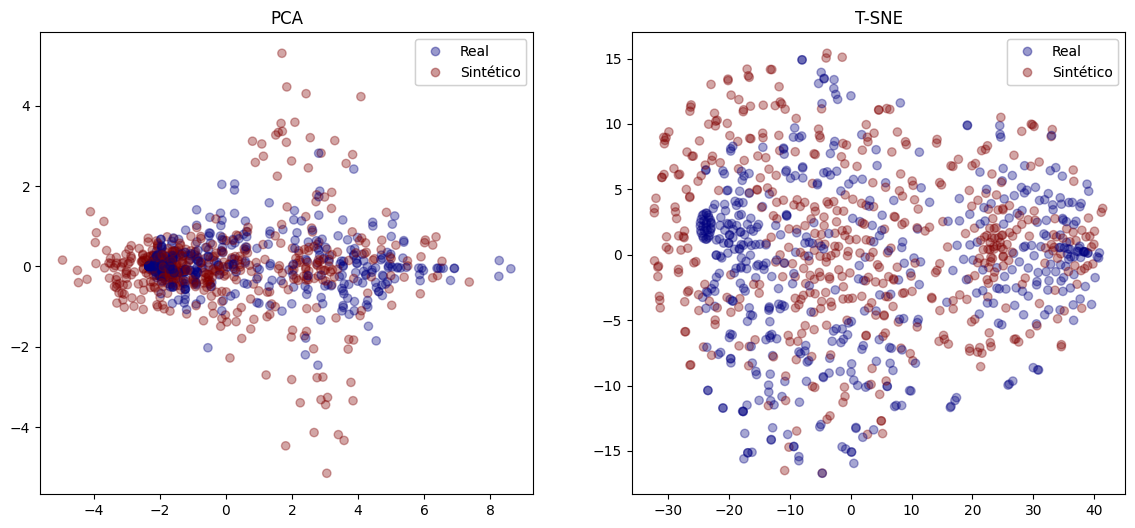

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_series_comparison(series1, series2, method='both'):
    """
    Plota a comparação entre duas séries temporais usando PCA e T-SNE.

    Args:
        series1 (np.ndarray): Primeira série temporal (n amostras, d dimensões).
        series2 (np.ndarray): Segunda série temporal (n amostras, d dimensões).
        method (str): 'pca' para apenas PCA, 'tsne' para apenas T-SNE, ou 'both' para ambos.

    Returns:
        None
    """
    assert series1.shape == series2.shape, "As séries devem ter o mesmo formato."

    #pega apenas mil amostras, aleatoriamente
    n_samples = 500
    indices = np.random.choice(series1.shape[0], n_samples, replace=False)
    series1 = series1[indices]
    series2 = series2[indices]

    # Intercala os dados
    interleaved_data = np.empty((series1.shape[0] + series2.shape[0], series1.shape[1]))
    interleaved_labels = np.empty(series1.shape[0] + series2.shape[0], dtype=int)

    interleaved_data[0::2] = series1
    interleaved_data[1::2] = series2
    interleaved_labels[0::2] = 0  # reais
    interleaved_labels[1::2] = 1  # sintéticos

    # Criando os subplots dinamicamente
    if method == 'both':
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        methods = ['PCA', 'T-SNE']
    else:
        fig, axes = plt.subplots(1, 1, figsize=(7, 6))
        methods = [method.upper()]
        axes = [axes]

    for ax, m in zip(axes, methods):
        if m == 'PCA':
            reducer = PCA(n_components=2)
        elif m == 'T-SNE':
            reducer = TSNE(n_components=2, perplexity=30, random_state=42)
        else:
            raise ValueError("Método inválido. Escolha 'pca', 'tsne' ou 'both'.")

        reduced = reducer.fit_transform(interleaved_data)
        scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c=interleaved_labels, cmap='jet', alpha=0.35)
        legend = ax.legend(*scatter.legend_elements())
        ax.add_artist(legend)
        legend.get_texts()[0].set_text("Real")
        legend.get_texts()[1].set_text("Sintético")
        #legenda para os dados artificiais e os reais

        ax.set_title(f"{m}")
    
    plt.show()

plot_series_comparison(x_train[:, :, 0, :].reshape(-1, seq_len), x_synt[:, :, 0, :].reshape(-1, seq_len), method='both')
